In [ ]:
!pip -q install albumentations

In [ ]:
#@title Imports
import os
import cv2
import random
import albumentations as A
from collections import Counter
from PIL import Image, ImageChops, ImageDraw, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms

# EXPLORATORY DATA ANALYSIS

In [ ]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/Projects/BUSI_dataset"

In [ ]:
#@title Checking images, classes and image types
extensions = ['.jpg', '.png', '.bmp', '.tif']
classes = ['Malignant', 'Benign']

def check_directories(paths):
    for path in paths:
        if not os.path.exists(path):
            raise Exception(f"Directory does not exist: {path}")

def list_files(directory):
    return os.listdir(directory)

def filter_files(files, extensions):
    return [file for file in files if os.path.splitext(file)[1].lower() in extensions]

def print_files(files, label):
    print(f"Number of {label} files: {len(files)}")
    for file in files:
        print(file)

def find_files(files, keywords, extensions):
    return [file for file in files if any(keyword in file for keyword in keywords) and os.path.splitext(file)[1].lower() in extensions]

def print_file_counts(label, images, lesions, masks):
    print(f"Total {label} items: \n images -> {len(images)}, lesions -> {len(lesions)}, masks -> {len(masks)}")
    print(f" Sum -> {len(images) + len(lesions) + len(masks)}")

In [ ]:
# Define paths
mal_path = os.path.join(data_dir, classes[0])
ben_path = os.path.join(data_dir, classes[1])

# Check if directories exist
check_directories([mal_path, ben_path])

# List and filter files
mal_files = list_files(mal_path)
ben_files = list_files(ben_path)
malignant_files = filter_files(mal_files, extensions)
benign_files = filter_files(ben_files, extensions)

# Print file information
print_files(malignant_files, 'malignant')
print_files(benign_files, 'benign')

# Find and print specific files
keywords = ["Image", "Lesion", "Mask"]

for label, files in [('malignant', malignant_files), ('benign', benign_files)]:
    masks = find_files(files, ["Mask"], ['.tif', '.bmp'])
    lesions = find_files(files, ["Lesion"], ['.tif', '.bmp'])
    images = find_files(files, ["Image"], extensions)

    for count, file in enumerate(masks):
        print(f'{count} - {file}')
    print(f'Number of {label} masks: {len(masks)}')

    for count, file in enumerate(lesions):
        print(f'{count} - {file}')
    print(f'Number of {label} lesions: {len(lesions)}')

    for count, file in enumerate(images):
        print(f'{count} - {file}')
    print(f'Number of {label} images: {len(images)}')

    print_file_counts(label, images, lesions, masks)

Number of malignant files: 369
11 Malignant Image.bmp
1 Malignant Image.bmp
2 Malignant Lesion.bmp
18 Malignant Lesion.bmp
12 Malignant Lesion.bmp
21 Malignant Mask.tif
7 Malignant Lesion.bmp
3 Malignant Lesion.bmp
2 Malignant Image.bmp
16 Malignant Mask.tif
24 Malignant Lesion.bmp
19 Malignant Mask.tif
14 Malignant Lesion.bmp
4 Malignant Image.bmp
3 Malignant Mask.tif
21 Malignant Lesion.bmp
16 Malignant Image.bmp
9 Malignant Lesion.bmp
23 Malignant Mask.tif
5 Malignant Lesion.bmp
8 Malignant Image.bmp
16 Malignant Lesion.bmp
17 Malignant Lesion.bmp
9 Malignant Mask.tif
19 Malignant Lesion.bmp
11 Malignant Lesion.bmp
20 Malignant Mask.tif
15 Malignant Mask.tif
12 Malignant Mask.tif
15 Malignant Image.bmp
15 Malignant Lesion.bmp
7 Malignant Mask.tif
17 Malignant Image.bmp
6 Malignant Mask.tif
18 Malignant Image.bmp
10 Malignant Image.bmp
21 Malignant Image.bmp
8 Malignant Lesion.bmp
11 Malignant Mask.tif
17 Malignant Mask.tif
2 Malignant Mask.tif
6 Malignant Image.bmp
22 Malignant Lesi

In [ ]:
def plot_sample_images(data_dir, class_label, files, sample_count=2):
    class_dir = os.path.join(data_dir, class_label)
    fig, axes = plt.subplots(1, sample_count, figsize=(10, 5))
    for i, file in enumerate(files[:sample_count]):
        img_path = os.path.join(class_dir, file)
        image = Image.open(img_path)
        axes[i].imshow(image)
        axes[i].set_title(f"{class_label} Sample {i+1}")
        axes[i].axis('off')
    plt.show()

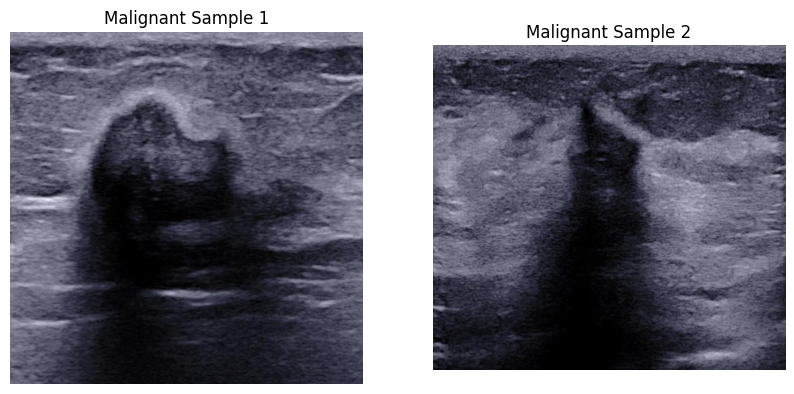

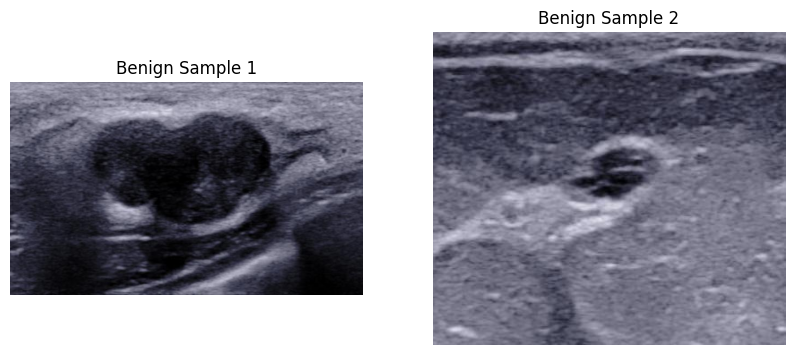

In [ ]:
# Plot sample images
plot_sample_images(data_dir, 'Malignant', find_files(malignant_files, ["Image"], extensions))
plot_sample_images(data_dir, 'Benign', find_files(benign_files, ["Image"], extensions))

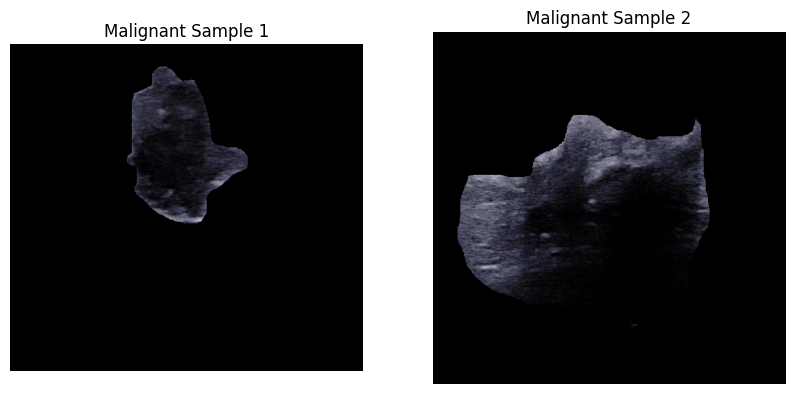

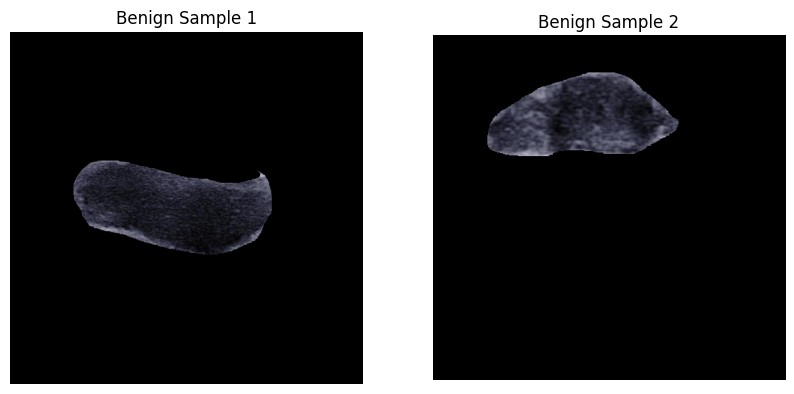

In [ ]:
# Plot sample lesions
plot_sample_images(data_dir, 'Malignant', find_files(malignant_files, ["Lesion"], ['.bmp', '.tif']))
plot_sample_images(data_dir, 'Benign', find_files(benign_files, ["Lesion"], ['.bmp', '.tif']))

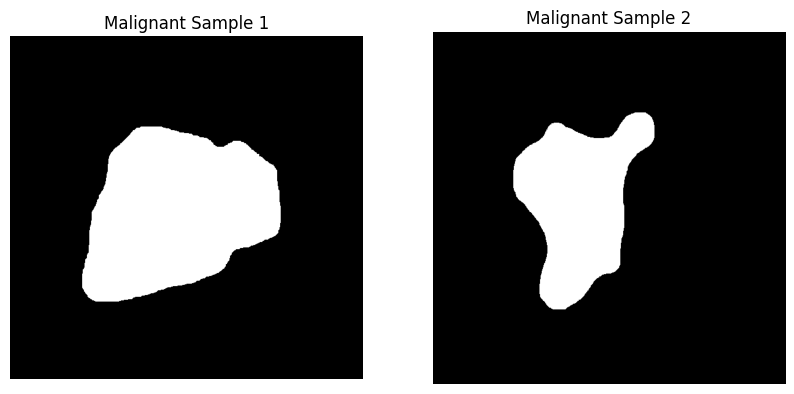

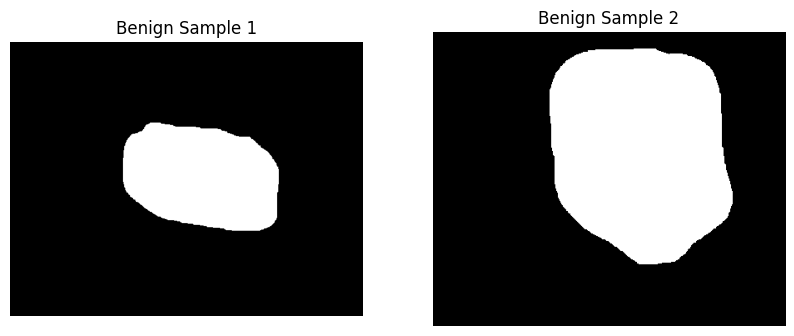

In [ ]:
# Plot sample masks
plot_sample_images(data_dir, 'Malignant', find_files(malignant_files, ["Mask"], ['.bmp', '.tif']))
plot_sample_images(data_dir, 'Benign', find_files(benign_files, ["Mask"], ['.bmp', '.tif']))

In [ ]:
#@title Visualizing image size and aspect ratio
def get_image_sizes(files, class_dir):
    sizes = []
    aspect_ratios = []
    for file in files:
        img_path = os.path.join(class_dir, file)
        image = Image.open(img_path)
        width, height = image.size
        sizes.append((width, height))
        aspect_ratios.append(width / height)
    return sizes, aspect_ratios

def plot_histogram(data, title, xlabel, ylabel):
    plt.hist(data, bins=30, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [ ]:
# Visualizing image size and aspect ratio
mal_sizes, mal_aspect_ratios = get_image_sizes(malignant_files, mal_path)

In [ ]:
ben_sizes, ben_aspect_ratios = get_image_sizes(benign_files, ben_path)

In [ ]:
# Flatten sizes to get width and height lists
mal_widths = [size[0] for size in mal_sizes]
mal_heights = [size[1] for size in mal_sizes]
ben_widths = [size[0] for size in ben_sizes]
ben_heights = [size[1] for size in ben_sizes]

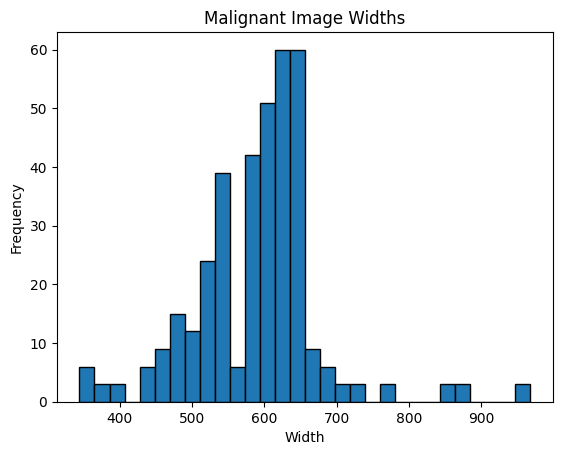

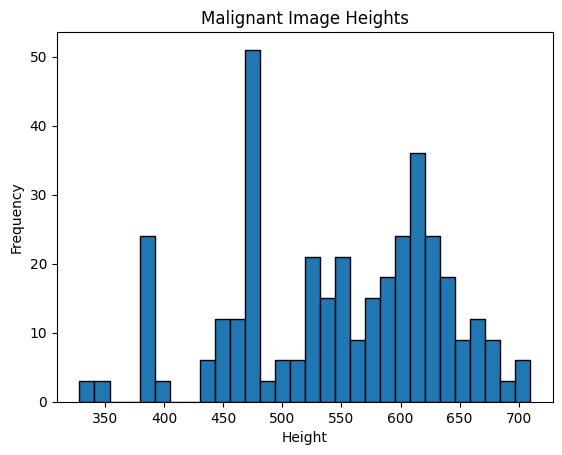

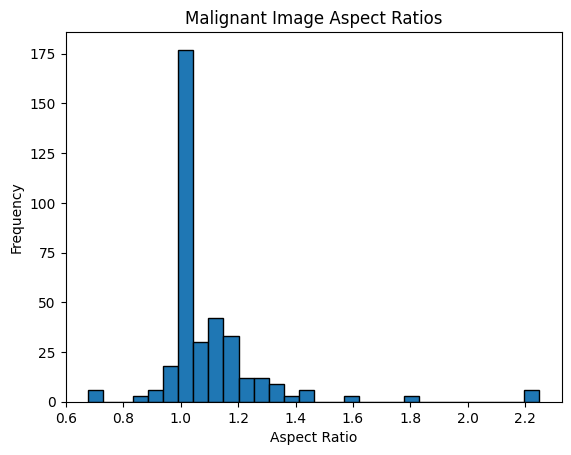

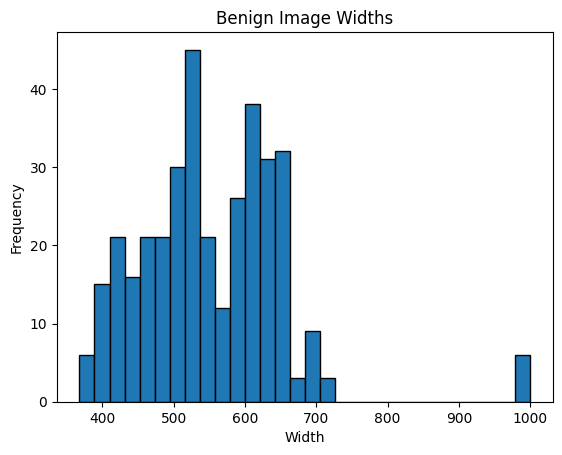

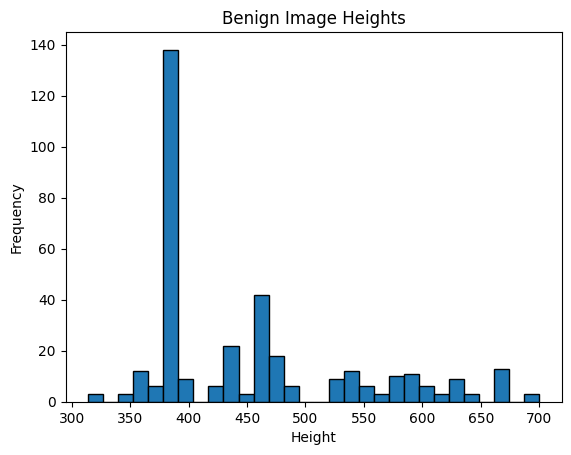

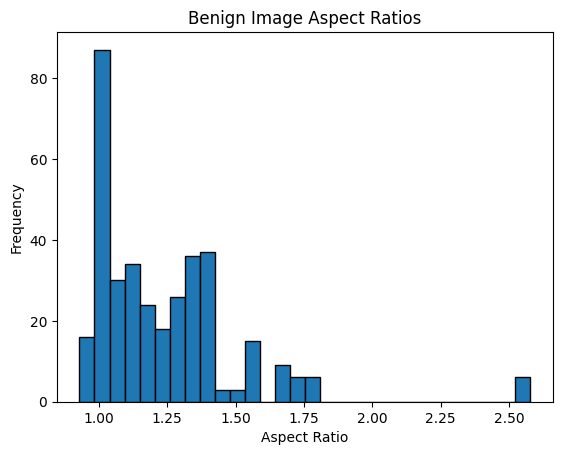

In [ ]:
# Plot histograms
plot_histogram(mal_widths, 'Malignant Image Widths', 'Width', 'Frequency')
plot_histogram(mal_heights, 'Malignant Image Heights', 'Height', 'Frequency')
plot_histogram(mal_aspect_ratios, 'Malignant Image Aspect Ratios', 'Aspect Ratio', 'Frequency')

plot_histogram(ben_widths, 'Benign Image Widths', 'Width', 'Frequency')
plot_histogram(ben_heights, 'Benign Image Heights', 'Height', 'Frequency')
plot_histogram(ben_aspect_ratios, 'Benign Image Aspect Ratios', 'Aspect Ratio', 'Frequency')

In [ ]:
all_sizes = mal_sizes + ben_sizes
all_aspect_ratios = mal_aspect_ratios + ben_aspect_ratios

most_common_size = Counter(all_sizes).most_common(1)[0][0]
most_common_aspect_ratio = Counter(all_aspect_ratios).most_common(1)[0][0]

print(f'Most common image size: {most_common_size}')
print(f'Most common aspect ratio: {most_common_aspect_ratio}')

# Save the most common size and aspect ratio for preprocessing
common_image_size = most_common_size
common_aspect_ratio = most_common_aspect_ratio

Most common image size: (620, 620)
Most common aspect ratio: 1.0


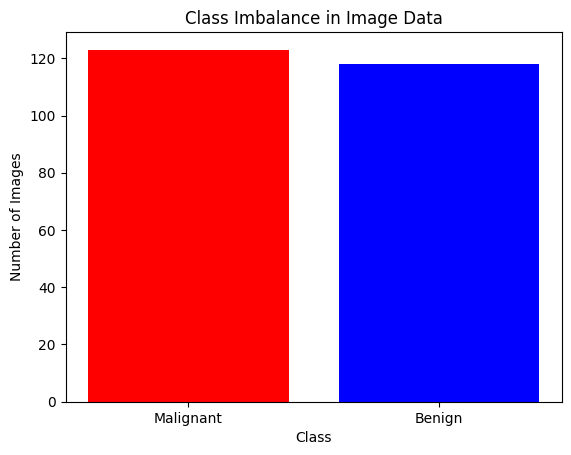

In [ ]:
#@title Plotting class imbalance
malignant_images = len(find_files(malignant_files, ["Image"], extensions))
benign_images = len(find_files(benign_files, ["Image"], extensions))
plt.bar(['Malignant', 'Benign'], [malignant_images, benign_images], color=['red', 'blue'])
plt.title('Class Imbalance in Image Data')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

In [ ]:
print(f'Malignant images: {malignant_images}')
print(f'Benign images: {benign_images}')

Malignant images: 123
Benign images: 118


# DATA PREPROCESSING

In [ ]:
#@title Creating directory for preprocessed files
# Define the main directory for preprocessed data
# preprocessed_data_dir = "/content/drive/MyDrive/Colab Notebooks/Projects/BUSI_bin_preprocessed"

# # Define subfolders
# subfolders = ['Malignant', 'Benign']

# # Create the main directory if it doesn't exist
# if not os.path.exists(preprocessed_data_dir):
#     os.makedirs(preprocessed_data_dir)

# # Create subfolders
# for subfolder in subfolders:
#     subfolder_path = os.path.join(preprocessed_data_dir, subfolder)
#     if not os.path.exists(subfolder_path):
#         os.makedirs(subfolder_path)

# print(f"Created directory structure at {preprocessed_data_dir} with subfolders {subfolders}")

In [ ]:
#@title Overlaying image with its lesion and mask
def draw_edges(image, overlay, color):
    """
    Draw edges of the overlay on the image using the specified color.
    """
    # Convert overlay to grayscale
    overlay_gray = overlay.convert('L')

    # Detect edges using a simple filter (e.g., edge detection)
    edges = overlay_gray.filter(ImageFilter.FIND_EDGES)

    # Convert edges to binary
    edges_binary = edges.point(lambda p: p > 0 and 255)  # 255 for edges

    # Create an RGBA image to draw edges
    edge_image = Image.new('RGBA', image.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(edge_image)

    # Combine the images
    combined_image = Image.alpha_composite(image.convert('RGBA'), edge_image)

    return combined_image.convert('RGB')

def find_corresponding_files(base_name, lesion_files, mask_files):
    # Find corresponding lesion and mask files based on the base_name
    lesion_file = next((file for file in lesion_files if base_name in file), None)
    mask_file = next((file for file in mask_files if base_name in file), None)
    return lesion_file, mask_file

def process_and_save_images(class_label, files, data_dir, preprocessed_data_dir):
    count=0
    class_dir = os.path.join(data_dir, class_label)
    preprocessed_class_dir = os.path.join(preprocessed_data_dir, class_label)

    images = find_files(files, ["Image"], extensions)
    lesions = find_files(files, ["Lesion"], ['.bmp', '.tif'])
    masks = find_files(files, ["Mask"], ['.bmp', '.tif'])

    for img_file in images:
        print(f'{count} -> {img_file}')
        base_name = "Image"  # Extract base name by removing the "Image" suffix
        base_name = os.path.splitext(img_file)[0].replace("Image", "").strip()

        lesion_file, mask_file = find_corresponding_files(base_name, lesions, masks)
        count+=1

        if lesion_file and mask_file:
            img_path = os.path.join(class_dir, img_file)
            lesion_path = os.path.join(class_dir, lesion_file)
            mask_path = os.path.join(class_dir, mask_file)

            image = Image.open(img_path)
            lesion = Image.open(lesion_path)
            mask = Image.open(mask_path)

            # Resize lesion and mask to match image size if necessary
            if image.size != lesion.size:
                lesion = lesion.resize(image.size)
            if image.size != mask.size:
                mask = mask.resize(image.size)

             # Overlay edges of lesion and mask onto the image
            overlayed_image = draw_edges(image, lesion, (255, 0, 0, 255))  # Red for lesion
            overlayed_image = draw_edges(overlayed_image, mask, (255, 255, 255, 255))  # White for mask

            # Save the resulting image
            save_path = os.path.join(preprocessed_class_dir, img_file)
            overlayed_image.save(save_path)
            print(f"Saved overlayed image: {save_path}")
        else:
            print(f"Could not find corresponding lesion or mask for {img_file}")


In [ ]:
preprocessed_dir = "/content/drive/MyDrive/Colab Notebooks/Projects/BUSI_bin_preprocessed"

In [ ]:
# import os
# from PIL import Image

# def check_image_dimensions(directory):
#     """
#     Check and print the dimensions of images in the given directory.
#     """
#     for class_label in os.listdir(directory):
#         class_dir = os.path.join(directory, class_label)

#         if os.path.isdir(class_dir):
#             print(f"Class: {class_label}")
#             for file_name in os.listdir(class_dir):
#                 if file_name.endswith(('.bmp', '.png', '.jpg', '.jpeg', '.tif')):
#                     img_path = os.path.join(class_dir, file_name)
#                     with Image.open(img_path) as img:
#                         width, height = img.size
#                         print(f"{file_name}: {width}x{height}")

# # Check dimensions of the images
# check_image_dimensions(preprocessed_dir)

In [ ]:
# # Process and save images for each class
# for class_label in classes:
#     class_path = os.path.join(data_dir, class_label)
#     files = list_files(class_path)
#     process_and_save_images(class_label, files, data_dir, preprocessed_dir)

# print("Processing and saving overlayed images completed.")

In [ ]:
#@title Augmenting images
def augment_image_advanced(image, output_dir, base_name, num_augmentations):
    """
    Apply advanced augmentations to the image and save the augmented versions.
    """
    # Define the augmentation pipeline
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        #A.RandomResizedCrop(height=650, width=650, p=1.0)
    ])

    # Convert PIL Image to NumPy array
    image_np = np.array(image)

    for i in range(num_augmentations):
        # Apply augmentations
        augmented = transform(image=image_np)
        augmented_image_np = augmented['image']

        # Convert back to PIL Image
        augmented_image = Image.fromarray(augmented_image_np)

        # Save the augmented image
        save_path = os.path.join(output_dir, f"{base_name}_aug_{i}.bmp")
        augmented_image.save(save_path)
        print(f"Saved augmented image: {save_path}")

In [ ]:
def process_and_augment_images_advanced(input_dir, output_dir, target_num_augmented_images):
    """
    Process and augment images from the input directory and save them to the output directory.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_label in os.listdir(input_dir):
        class_dir = os.path.join(input_dir, class_label)
        output_class_dir = os.path.join(output_dir, class_label)

        if not os.path.exists(output_class_dir):
            os.makedirs(output_class_dir)

        files = [f for f in os.listdir(class_dir) if f.endswith('.bmp')]
        num_files = len(files)
        num_augmentations = max(1, target_num_augmented_images // num_files)  # Ensure at least one augmentation per image

        for file_name in files:
            img_path = os.path.join(class_dir, file_name)
            image = Image.open(img_path)

            # Augment the image
            base_name = os.path.splitext(file_name)[0]
            augment_image_advanced(image, output_class_dir, base_name, num_augmentations)

In [ ]:
output_dir = "/content/drive/MyDrive/Colab Notebooks/Projects/BUSI_bin_augmented"
target_num_augmented_images = 330

process_and_augment_images_advanced(preprocessed_dir, output_dir, target_num_augmented_images)
print("Advanced image augmentation completed.")

Saved augmented image: /content/drive/MyDrive/Colab Notebooks/Projects/BUSI_bin_augmented/Malignant/3 Malignant Image_aug_0.bmp
Saved augmented image: /content/drive/MyDrive/Colab Notebooks/Projects/BUSI_bin_augmented/Malignant/3 Malignant Image_aug_1.bmp
Saved augmented image: /content/drive/MyDrive/Colab Notebooks/Projects/BUSI_bin_augmented/Malignant/3 Malignant Image_aug_2.bmp
Saved augmented image: /content/drive/MyDrive/Colab Notebooks/Projects/BUSI_bin_augmented/Malignant/13 Malignant Image_aug_0.bmp
Saved augmented image: /content/drive/MyDrive/Colab Notebooks/Projects/BUSI_bin_augmented/Malignant/13 Malignant Image_aug_1.bmp
Saved augmented image: /content/drive/MyDrive/Colab Notebooks/Projects/BUSI_bin_augmented/Malignant/13 Malignant Image_aug_2.bmp
Saved augmented image: /content/drive/MyDrive/Colab Notebooks/Projects/BUSI_bin_augmented/Malignant/19 Malignant Image_aug_0.bmp
Saved augmented image: /content/drive/MyDrive/Colab Notebooks/Projects/BUSI_bin_augmented/Malignant/